# 近端策略优化(Proximal Policy Optimization, PPO)

PPO是一种基于策略梯度的强化学习算法，旨在提高训练的稳定性和效率。它通过限制每次更新的幅度来避免过大的策略变化，从而实现更平滑的学习过程。

PPO（Proximal Policy Optimization）算法需要了解以下核心内容：

1. **策略梯度方法基础**  
   - 理解策略网络、价值网络、策略梯度的基本原理。

2. **重要性采样（Importance Sampling）**  
   - 理解旧策略和新策略的概率比（ratio），即 $\frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$，用于修正 off-policy 采样带来的偏差。

3. **剪切目标（Clipped Objective）**  
   - PPO 的核心创新是引入剪切损失，防止策略更新过大，保证训练稳定性。

4. **优势函数（Advantage Function）**  
   - 用于衡量当前动作相对于平均水平的好坏，常用 GAE（Generalized Advantage Estimation）进行优势估计。

5. **批量采样与多步更新**  
   - PPO 通常收集一批（batch）数据，然后用 mini-batch 多次更新网络参数。

6. **损失函数设计**  
   - 包括策略损失（剪切目标）、价值损失、熵正则项（鼓励探索）。

7. **训练流程**  
   - 采样、计算优势、计算损失、梯度下降、更新旧策略参数。

8. **超参数选择**  
   - 如 clip range、batch size、update epochs、学习率等对 PPO 性能影响较大。
  
## Actor

TRPO通过设置信任区域限制策略更新幅度，PPO则通过剪切目标函数来实现类似的效果。在PPO算法中，Actor的目标是最大化期望回报，同时限制每次策略更新的幅度。其优化目标函数为：

$$
\arg\max_{\theta} \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}},}\mathbb{E}_{a \sim \pi_{\theta_k}(\cdot|s)} \left[
    \min \left(
        \frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s, a),\,
        \operatorname{clip}\left(
            \frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)},\, 1-\epsilon,\, 1+\epsilon
        \right) A^{\pi_{\theta_k}}(s, a)
    \right)
\right]
$$ 


其中，$A^{\pi_{\theta_k}}(s, a)$是优势函数，$\epsilon$是剪切范围。优势函数一般可以用广义优势估计（GAE）来计算。

GAE的计算公式为：

$$
A_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots
$$

其中$\delta_t$是时刻$t$的TD误差，$\gamma$是折扣因子，$\lambda$是GAE的平滑参数。GAE可以有效地减少方差，提高策略梯度估计的稳定性。

由其优化目标可得知Actor的损失函数为：

$$
L^{\text{actor}}(\theta) = -\mathbb{E}_{t} \left[
    \min \left(
        r_t(\theta) \hat{A}_t,\;
        \operatorname{clip}\left(r_t(\theta),\; 1-\epsilon,\; 1+\epsilon\right) \hat{A}_t
    \right)
\right]
$$


## Critic

Critic的目标是最小化当前策略下的价值函数与真实回报之间的均方误差。PPO中Critic的损失函数为：

$$
L^{\text{critic}}(\theta) = \mathbb{E}_{t} \left[
    \left(V_{\theta}(s_t) - V_{\text{target}}(s_t)\right)^2
\right]
$$
其中$V_{\text{target}}(s_t)$是当前状态$s_t$的目标值，通常可以通过蒙特卡洛方法或TD方法来计算。

一般是时序差分目标：

$$
V_{\text{target}}(s_t) = r_t + \gamma V_{\theta}(s_{t+1})
$$
或者使用GAE：
$$
V_{\text{target}}(s_t) = r_t + \gamma \left(\delta_t + \lambda \delta_{t+1} + \cdots\right)
$$

## References

1. [PPO - 知乎](https://zhuanlan.zhihu.com/p/659864750)
2. [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym

In [5]:
# Actor, input is state, output is action probabilities
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # softmax for action probabilities
        x = torch.softmax(self.fc2(x), dim=-1)
        return x


# Critic, input is state, output is value
class ValueNetwork(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
actor = PolicyNetwork(state_dim=4, action_dim=2)
critic = ValueNetwork(state_dim=4)

print(actor)
print(critic)

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
ValueNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


## some tricks:

1. **熵正则化**  
   
   为了鼓励策略的探索性，可以在策略网络损失函数中加入熵项，增加策略的随机性。熵正则化项可以表示为：
$$
H(\pi_\theta) = -\mathbb{E}_{s \sim \nu^{\pi_{\theta_k}},}\mathbb{E}_{a \sim \pi_\theta(\cdot|s)} \left[
    \log \pi_\theta(a|s)
\right]
$$
   最终的损失函数为：
$$
L(\theta) = L^{\text{actor}}(\theta) - c H(\pi_\theta)
$$
   其中$c$是超参数，用于平衡熵正则化项，该值可随着训练的进行逐渐减小。

2. **多步更新**
   
   PPO通常使用多步更新来提高样本效率。可以在每次更新中使用多个时间步的数据进行训练，而不是仅依赖于单个时间步的数据。这可以通过将数据分成多个小批次来实现。

3. **优势函数的归一化**
   
   在计算优势函数时，可以对其进行归一化处理，以减少方差。常用的方法是将优势函数减去其均值并除以标准差。

In [20]:
class PPO:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        policy_lr: float = 3e-4,
        value_lr: float = 3e-4,
        device: str = "cpu",
        gamma: float = 0.99,  # for discounting future rewards
        lam: float = 0.95,  # for GAE
        clip_epsilon: float = 0.2,  # for clipping the policy ratio
    ):
        self.policy_net = PolicyNetwork(state_dim=state_dim, action_dim=action_dim).to(
            device
        )
        self.value_net = ValueNetwork(state_dim=state_dim).to(device)
        self.policy_optimizer = torch.optim.Adam(
            self.policy_net.parameters(), lr=policy_lr
        )
        self.value_optimizer = torch.optim.Adam(
            self.value_net.parameters(), lr=value_lr
        )
        self.gamma = gamma
        self.lam = lam
        self.clip_epsilon = clip_epsilon

    def select_action(self, state):
        """
        Select an action based on the current policy.

        Args:
            state (np.ndarray): Current state.
        Returns:
            int: Selected action.
        """
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs = self.policy_net(state)
        action = torch.distributions.Categorical(action_probs).sample()
        return action

    def compute_advantages(
        self, rewards: list, values: list, next_values: list, dones: list
    ):
        """
        Compute Generalized Advantage Estimation (GAE) for the given rewards and values.

        Args:
            rewards (list): List of rewards.
            values (list): List of state values.
            next_values (list): List of next state values.
            dones (list): List of done flags.
        Returns:
            list: List of advantages.
        """
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = (
                rewards[t] + (1 - dones[t]) * self.gamma * next_values[t] - values[t]
            )
            gae = delta + (1 - dones[t]) * self.gamma * self.lam * gae
            advantages.insert(0, gae)
        return advantages

    def update(
        self,
        states: list,
        actions: list,
        rewards: list,
        next_states: list,
        dones: list,
        old_log_probs: list,
        entropy_coeff: float = 0.01,
        policy_lr: float = 3e-4,
        value_lr: float = 3e-4,
    ):
        # update the policy network and value network
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        old_log_probs = torch.FloatTensor(old_log_probs)

        # Compute values and next values
        values = self.value_net(states).squeeze()
        next_values = self.value_net(next_states).squeeze()
        # Compute advantages
        advantages = self.compute_advantages(
            rewards, values.detach(), next_values.detach(), dones
        )
        advantages = torch.FloatTensor(advantages)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Compute new log probabilities
        # [batch_size, action_dim] -> [batch_size, 1] -> [batch_size] -> [batch_size]
        new_log_probs = torch.log(
            self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        )
        # Compute the policy loss
        ratios = torch.exp(new_log_probs - old_log_probs)
        surrogate1 = ratios * advantages
        surrogate2 = (
            torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
            * advantages
        )
        policy_loss = -torch.min(surrogate1, surrogate2).mean()
        # Add entropy loss for exploration
        entropy = (
            torch.distributions.Categorical(self.policy_net(states)).entropy().mean()
        )
        policy_loss = policy_loss - entropy_coeff * entropy

        # Compute value loss
        td_target = rewards + (1 - dones) * self.gamma * next_values
        value_loss = F.mse_loss(values, td_target.detach())

        # Update the policy and value networks
        for param_group in self.policy_optimizer.param_groups:
            param_group["lr"] = policy_lr
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        for param_group in self.value_optimizer.param_groups:
            param_group["lr"] = value_lr
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

# Training Process

使用当前策略与环境交互，收集状态、动作、奖励和下一个状态的数据。每个episode训练多个epoch，更新策略和价值网络。

In [21]:
env = gym.make("CartPole-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_lr = 1e-3
value_lr = 1e-2
gamma = 0.99
lam = 0.95
clip_epsilon = 0.2

num_episodes = 1000
max_timesteps = 500
num_epochs = 10

ppo = PPO(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.n,
    policy_lr=policy_lr,
    value_lr=value_lr,
    device=device,
    gamma=gamma,
    lam=lam,
    clip_epsilon=clip_epsilon,
)

total_rewards = []
total_timesteps = []

In [22]:
def get_lr(step: int, max_steps: int, initial_lr: float):
    """
    Coisine annealing learning rate schedule.
    """
    return initial_lr * (1 + np.cos(np.pi * step / max_steps)) / 2

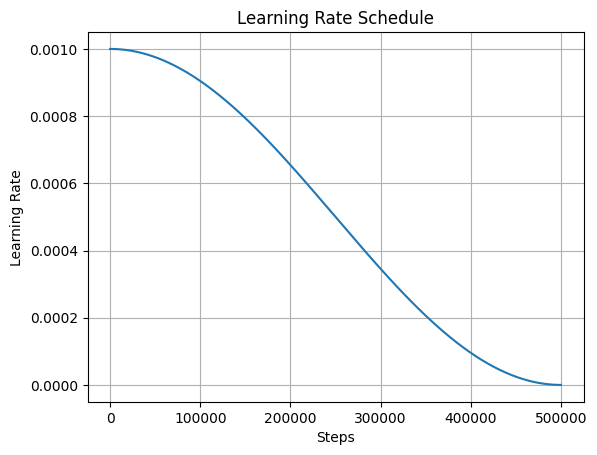

In [23]:
# Draw the learning rate curve
def plot_lr_curve():
    steps = np.arange(0, num_episodes * max_timesteps)
    lrs = [get_lr(step, num_episodes * max_timesteps, policy_lr) for step in steps]
    plt.plot(steps, lrs)
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid()
    plt.show()
plot_lr_curve()

In [24]:
# Training loop
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_timesteps = 0
    done = False

    states, actions, rewards, next_states, dones = [], [], [], [], []

    while not done and episode_timesteps < max_timesteps:
        # Select action
        action = ppo.select_action(state)
        # Take action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        # Store transition
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        done = terminated or truncated
        dones.append(done)

        state = next_state
        episode_timesteps += 1

    # Update the policy and value networks
    old_log_probs = (
        torch.log(
            ppo.policy_net(torch.FloatTensor(states)).gather(
                1, torch.LongTensor(actions).unsqueeze(1)
            )
        )
        .squeeze()
        .detach()
    ).tolist()
    for epoch in range(num_epochs):
        policy_lr = get_lr(
            episode * num_epochs + epoch, num_episodes * num_epochs, policy_lr
        )
        value_lr = get_lr(
            episode * num_epochs + epoch, num_episodes * num_epochs, value_lr
        )
        entropy_coeff = 0.01 * (1 - episode / num_episodes)
        ppo.update(
            states,
            actions,
            rewards,
            next_states,
            dones,
            old_log_probs,
            entropy_coeff=entropy_coeff,
            policy_lr=policy_lr,
            value_lr=value_lr,
        )

    total_rewards.append(sum(rewards))
    total_timesteps.append(episode_timesteps)

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {sum(rewards)}")
env.close()

Episode 10/1000, Reward: 31.0
Episode 20/1000, Reward: 50.0
Episode 30/1000, Reward: 75.0
Episode 40/1000, Reward: 134.0
Episode 50/1000, Reward: 246.0
Episode 60/1000, Reward: 479.0
Episode 70/1000, Reward: 167.0
Episode 80/1000, Reward: 162.0
Episode 90/1000, Reward: 183.0
Episode 100/1000, Reward: 164.0
Episode 110/1000, Reward: 309.0
Episode 120/1000, Reward: 170.0
Episode 130/1000, Reward: 229.0
Episode 140/1000, Reward: 349.0
Episode 150/1000, Reward: 395.0
Episode 160/1000, Reward: 423.0
Episode 170/1000, Reward: 247.0
Episode 180/1000, Reward: 443.0
Episode 190/1000, Reward: 349.0
Episode 200/1000, Reward: 280.0
Episode 210/1000, Reward: 500.0
Episode 220/1000, Reward: 428.0
Episode 230/1000, Reward: 276.0
Episode 240/1000, Reward: 500.0
Episode 250/1000, Reward: 299.0
Episode 260/1000, Reward: 500.0
Episode 270/1000, Reward: 171.0
Episode 280/1000, Reward: 353.0
Episode 290/1000, Reward: 298.0
Episode 300/1000, Reward: 298.0
Episode 310/1000, Reward: 121.0
Episode 320/1000, Re

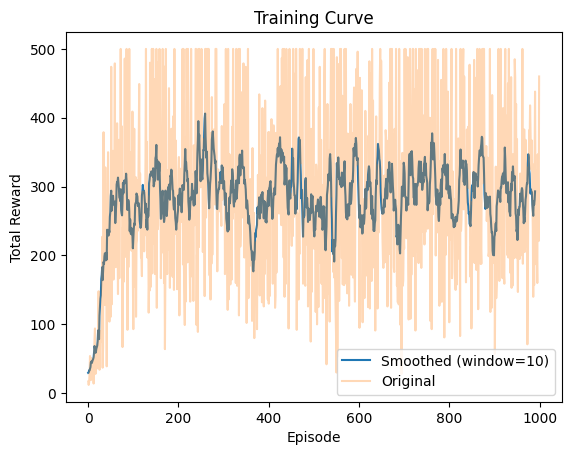

In [25]:
# Draw the results
def draw_train_curve(total_rewards, smooth_window=10):
    rewards = np.array(total_rewards)
    if len(rewards) >= smooth_window:
        # Simple moving average for smoothing
        smooth_rewards = np.convolve(
            rewards, np.ones(smooth_window) / smooth_window, mode="valid"
        )
        plt.plot(
            range(len(smooth_rewards)),
            smooth_rewards,
            label=f"Smoothed (window={smooth_window})",
        )
    plt.plot(rewards, alpha=0.3, label="Original")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Curve")
    plt.legend()
    plt.show()


draw_train_curve(total_rewards, smooth_window=10)

In [ ]:
# Evaluate the agent

env = gym.make("CartPole-v1", render_mode="human")
state, _ = env.reset()
done = False
while not done:
    action = ppo.select_action(state)
    state, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated